# Absentee Analysis

### Data Exploration

- Before we can do any analysis, we must first dive into the data and understand it first.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
df = pd.read_csv('absenteeism_data.csv', sep=';')
print("on fariha branch")
df.head()

# look at Social Drinker column. we have both "Y" and "Yes".
# there are also lots of NaN values

on fariha branch


,ID,Reason for absence,Month of absence,Day of the week,Seasons,Days since previous absence,Transportation expense,Distance from Residence to Work,Estimated commute time,Service time,Years until retirement,Date of Birth,Disciplinary failure,Education,Number of children,Social drinker,Social smoker,Number of pets,Weight,Height,Body mass index,Absenteeism time in hours
0,11,Unjustified absence,July,Tuesday,Summer,0.0,289,36,69,13,32,1992-08-15,No,1,2,Y,No,1,90,172,30,4
1,36,Unspecified,July,Tuesday,NaN,0.0,118,13,26,18,15,1975-09-02,Yes,1,1,Y,No,0,98,178,31,0
2,3,Medical consultation,July,Wednesday,Summer,0.0,179,51,108,18,27,1987-04-08,No,1,0,Yes,No,0,89,170,31,2
3,7,Diseases of the eye and adnexa,July,Thursday,NaN,0.0,279,5,5,14,26,1986-07-25,No,1,2,Yes,Yes,0,68,168,24,4
4,11,Medical consultation,July,Thursday,Summer,0.0,289,36,69,13,32,1992-08-15,No,1,2,Yes,No,1,90,172,30,2


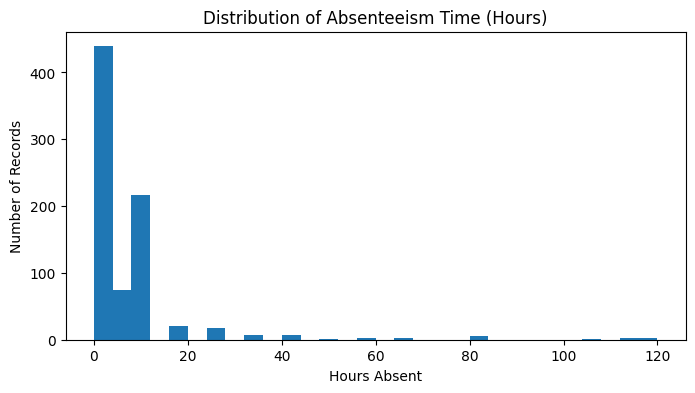

In [3]:
# First, lets visualize the distribution of how many entries correspond with how many hours were absent (via a histogram)
plt.figure(figsize=(8,4))
plt.hist(df['Absenteeism time in hours'], bins=30)
plt.title("Distribution of Absenteeism Time (Hours)")
plt.xlabel("Hours Absent")
plt.ylabel("Number of Records")
plt.show()

# note: some outliers

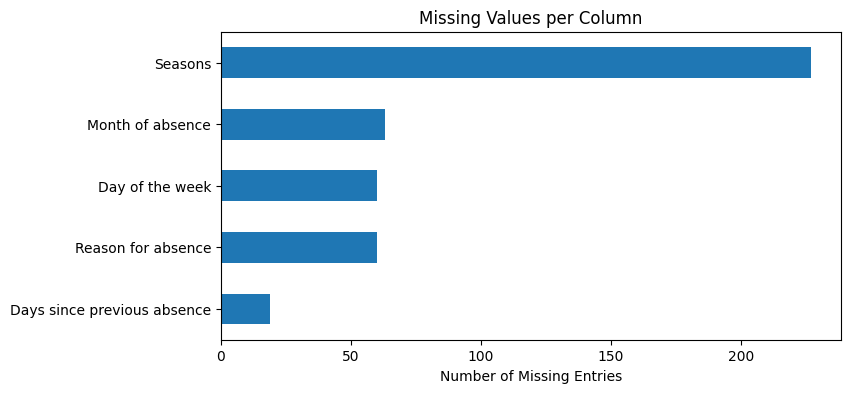

In [4]:
# Let's identify where we are missing values in our dataset
missing = df.isna().sum()
missing = missing[missing > 0]

plt.figure(figsize=(8,4))
missing.sort_values().plot(kind='barh')
plt.title("Missing Values per Column")
plt.xlabel("Number of Missing Entries")
plt.show()

# note: lots of missing data we need to pre-process properly

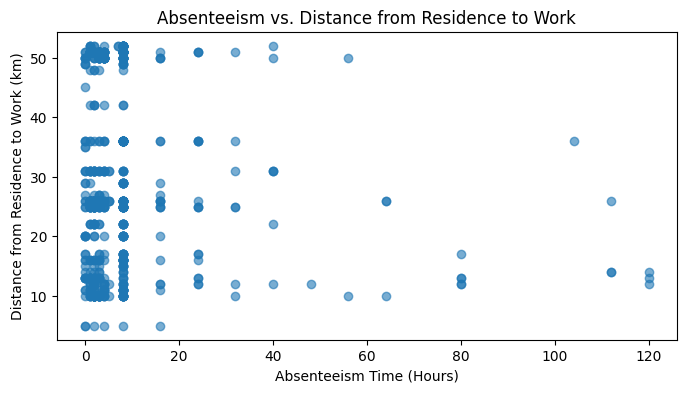

In [5]:
# Let's do a comparison between being absent and the distance they live from work.

plt.figure(figsize=(8,4))
plt.scatter(df['Absenteeism time in hours'], df['Distance from Residence to Work'], alpha=0.6)
plt.title("Absenteeism vs. Distance from Residence to Work")
plt.xlabel("Absenteeism Time (Hours)")
plt.ylabel("Distance from Residence to Work (km)")
plt.show()

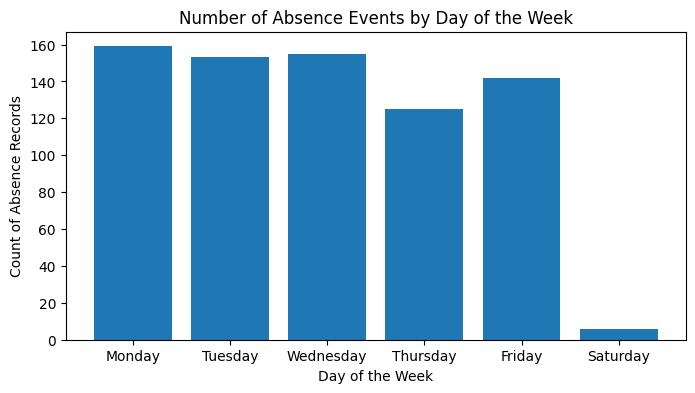

In [6]:
# Is there a correlation between the day of the week and absenteeism?
day_counts = df['Day of the week'].value_counts()

# I want the graph to visualize it in order from Monday - Sunday (not alphabetical)
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_counts = day_counts.reindex(weekday_order)

plt.figure(figsize=(8,4))
plt.bar(day_counts.index, day_counts.values)
plt.title("Number of Absence Events by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Count of Absence Records")
plt.show()


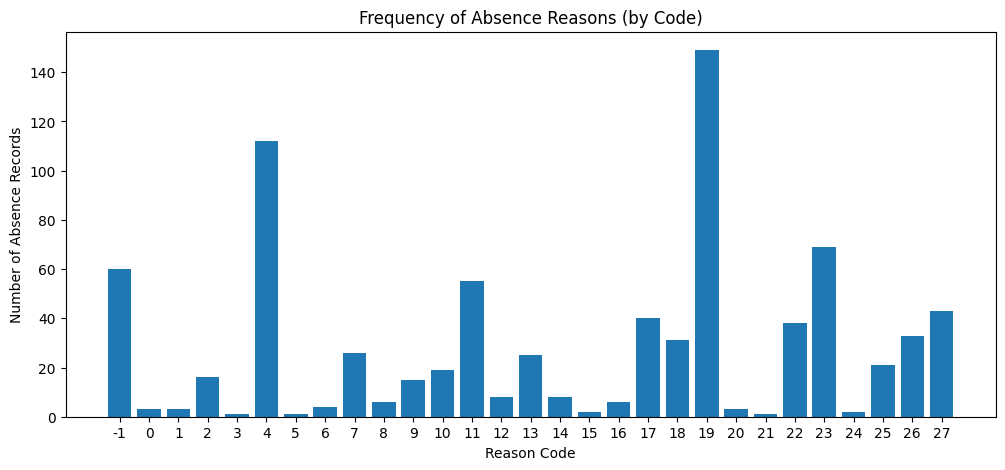

,Reason Code,Reason for absence
0,-1,NaN
1,0,Blood donation
2,1,Certain conditions originating in the perinata...
3,2,Certain infectious and parasitic diseases
4,3,"Congenital malformations, deformations and chr..."
5,4,Dental consultation
6,5,Diseases of the blood and blood-forming organs...
7,6,Diseases of the circulatory system
8,7,Diseases of the digestive system
9,8,Diseases of the ear and mastoid process


In [7]:
# Assign a numeric code to each reason
df['Reason Code'] = df['Reason for absence'].astype('category').cat.codes

reason_counts = df['Reason Code'].value_counts().sort_index()

plt.figure(figsize=(12,5))
plt.bar(reason_counts.index.astype(str), reason_counts.values)
plt.title("Frequency of Absence Reasons (by Code)")
plt.xlabel("Reason Code")
plt.ylabel("Number of Absence Records")
plt.show()

# Create the corresponding code table as a reference
reason_lookup = (
    df[['Reason Code', 'Reason for absence']]
    .drop_duplicates()
    .sort_values("Reason Code")
    .reset_index(drop=True)
)

reason_lookup


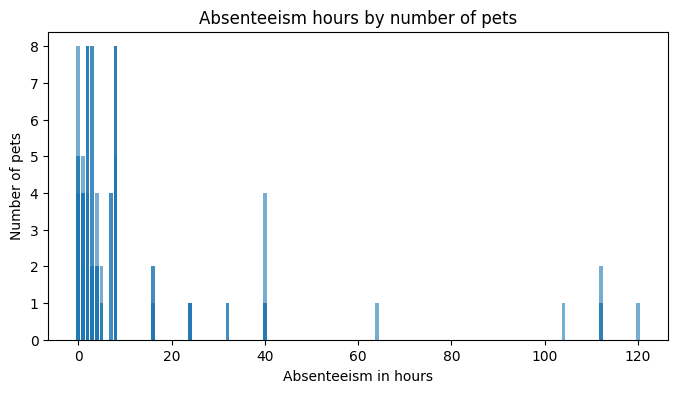

In [8]:
# analyse between pet ownership and higher number of absent hours

plt.figure(figsize=(8,4))
plt.bar(df['Absenteeism time in hours'], df['Number of pets'], alpha=0.6)
plt.title("Absenteeism hours by number of pets")
plt.xlabel("Absenteeism in hours")
plt.ylabel("Number of pets")
plt.show()



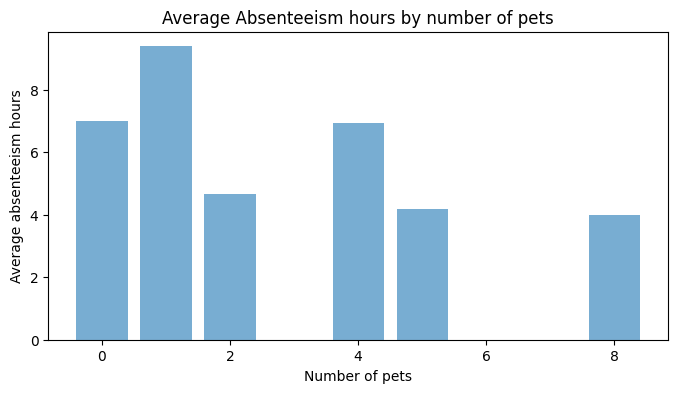

In [9]:
# group pets to get average absenteeism hours
pet_absence = df.groupby('Number of pets')['Absenteeism time in hours'].mean().reset_index()

plt.figure(figsize=(8,4))
plt.bar(pet_absence ['Number of pets'], pet_absence['Absenteeism time in hours'], alpha=0.6)
plt.title("Average Absenteeism hours by number of pets")
plt.xlabel("Number of pets")
plt.ylabel("Average absenteeism hours")
plt.show()

In [10]:
df[['Absenteeism time in hours', 'Service time']] #check two coloumns only


,Absenteeism time in hours,Service time
0,4,13
1,0,18
2,2,18
3,4,14
4,2,13
...,...,...
795,8,13
796,4,14
797,0,13
798,0,14


In [11]:
#service time in catagories
sorted(df['Service time'].unique())

['-',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '24',
 '29',
 '3',
 '4',
 '6',
 '7',
 '8',
 '9']

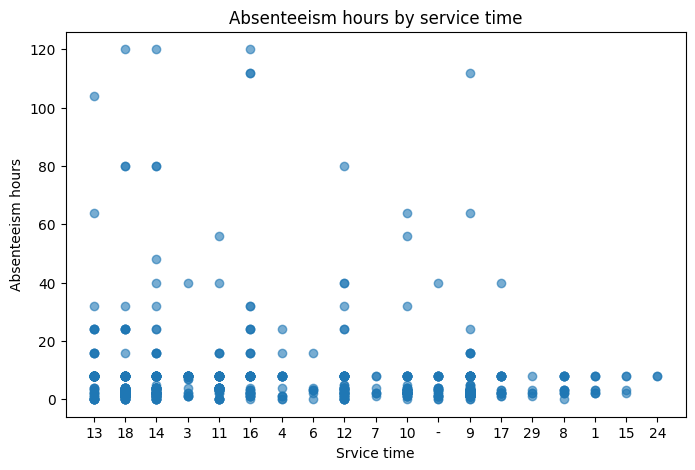

In [12]:
#comparison between absenteeism hours and service time
plt.figure(figsize=(8,5))
plt.scatter(df['Service time'], df['Absenteeism time in hours'], alpha=0.6)
plt.title('Absenteeism hours by service time')
plt.xlabel('Srvice time')
plt.ylabel('Absenteeism hours')
plt.show()

<Figure size 1000x600 with 0 Axes>

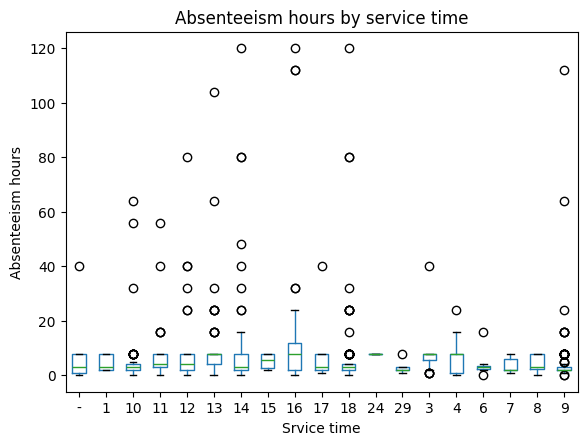

In [13]:
#compare absenteeism hrs by service time using boxplot
plt.figure(figsize=(10,6))
df.boxplot(column='Absenteeism time in hours', by='Service time', grid=False)
plt.title('Absenteeism hours by service time')
plt.suptitle('')
plt.xlabel('Srvice time')
plt.ylabel('Absenteeism hours')
plt.show()


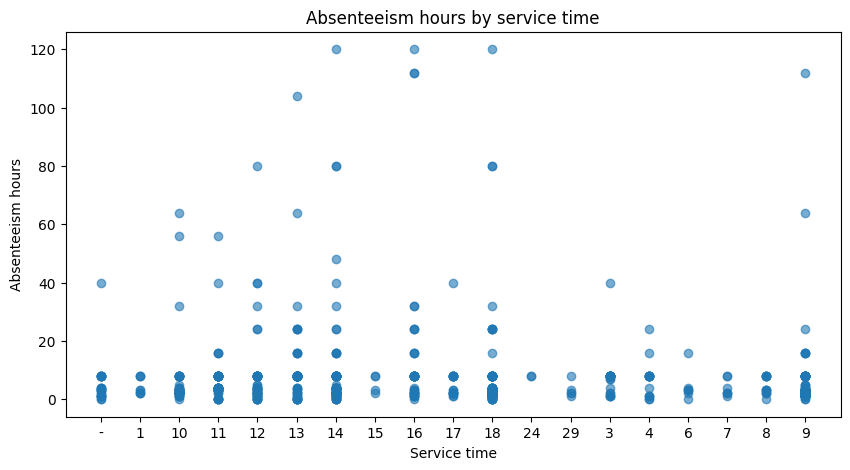

In [14]:
#sort the service time
df_sorted = df.sort_values('Service time')

plt.figure(figsize=(10,5))
plt.scatter(df_sorted['Service time'], df_sorted['Absenteeism time in hours'], alpha=0.6)
plt.title('Absenteeism hours by service time')
plt.xlabel('Service time')
plt.ylabel('Absenteeism hours')
plt.show()


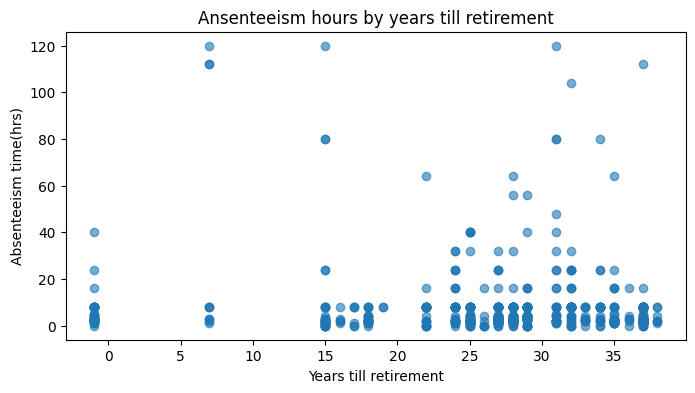

In [15]:
#Compare Absenteesim hours and Years until retirement

plt.figure(figsize=(8,4))
plt.scatter(df['Years until retirement'], df['Absenteeism time in hours'], alpha=0.6)
plt.title('Ansenteeism hours by years till retirement')
plt.xlabel('Years till retirement')
plt.ylabel('Absenteeism time(hrs)')
plt.show()



In [16]:
import seaborn as sns 

<Axes: xlabel='Absenteeism time in hours', ylabel='Service time'>

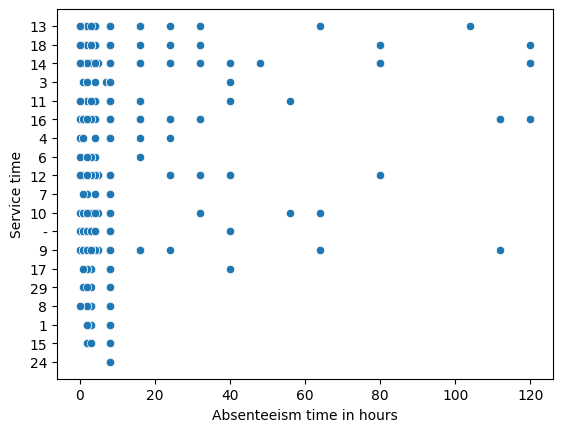

In [17]:
#Absenteeism hrs vs service time using seaborn (service time catagory changes, better graph in GoogleColab)
sns.scatterplot(data=df, x='Absenteeism time in hours', y='Service time')

<Axes: xlabel='Absenteeism time in hours', ylabel='Number of pets'>

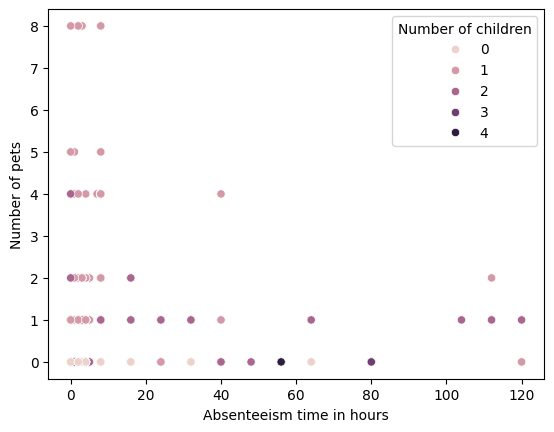

In [18]:
#scatterplot showing absent hr by number of pets with hue=number of childern
sns.scatterplot(data=df, x='Absenteeism time in hours', y='Number of pets', hue='Number of children')

In [19]:
#check duplicates only based on ID, Month of absence, Day of the week, Absenteeism time in hours
potential_duplicates = df[df.duplicated(subset=['ID', 'Month of absence', 'Day of the week', 'Absenteeism time in hours'])] 
print(potential_duplicates)

     ID      Reason for absence Month of absence Day of the week Seasons  \
13   20                     NaN              NaN             NaN     NaN   
19    3    Medical consultation             July          Friday  Summer   
43   20    Medical consultation           August          Friday  Summer   
74   34    Medical consultation          October         Tuesday  Spring   
96   28    Medical consultation         November       Wednesday  Spring   
..   ..                     ...              ...             ...     ...   
757  15     Dental consultation              May        Thursday  Winter   
758  22           Physiotherapy              May          Friday  Winter   
759  22                     NaN              NaN             NaN     NaN   
769  23       Patient follow-up             June        Thursday  Winter   
779  34  Laboratory examination             June          Monday  Summer   

     Days since previous absence  Transportation expense  \
13                         

In [29]:
#check for rows where all values are NaN
mostly_empty_rows=df[df.isnull().mean(axis=1) >0.8]
print(f"Found {len(mostly_empty_rows)} rows that are 80% empty")

Found 0 rows that are 80% empty


In [ ]:
#find all duplicate rows 
duplicates = df[df.duplicated(keep=False)]

print(f"Found {len(duplicates)} duplicate rows")
print("\nFirst 5 duplicate rows:")
duplicates.head(40)
print(duplicates)

Found 48 duplicate rows

First 5 duplicate rows:
     ID      Reason for absence Month of absence Day of the week Seasons  \
11   20                     NaN              NaN             NaN     NaN   
13   20                     NaN              NaN             NaN     NaN   
68    3                     NaN              NaN             NaN     NaN   
69   34    Medical consultation          October         Tuesday  Spring   
74   34    Medical consultation          October         Tuesday  Spring   
113  10       Patient follow-up         December       Wednesday     NaN   
116  28    Medical consultation         December         Tuesday  Spring   
117  10       Patient follow-up         December       Wednesday     NaN   
130  28                     NaN              NaN             NaN     NaN   
131  34           Physiotherapy          January          Monday  Autumn   
133  34           Physiotherapy          January         Tuesday  Autumn   
137  34           Physiotherapy        